## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values
        
##### Developed by: Pradeep Kumar S

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
# importing required libraries
from matplotlib import pyplot as plt
from TCGame_Env import TicTacToe
from tqdm import tqdm
import collections
import numpy as np
import random
import pickle
import time

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    """Replaces NaNs with string 'x'"""
    return ('-'.join(str(e) for e in state)).replace('nan', 'x')

In [3]:
# creating an object for environment - MDP for TicTacToe game
env = TicTacToe()

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    """Takes all valid actions from the env action space"""
    valid_Actions = [i for i in env.action_space(state)[0]]  ###### -------please call your environment as env
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    """Adds state to the q_state dictionary"""
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

In [6]:
# the first initialized state - default tictactoe board positions
Q_state(env.state)

'x-x-x-x-x-x-x-x-x'

In [7]:
# the available action space for the agent
print(valid_actions(env.state))  # we can see all odd moves avaliable for agent

[(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (1, 1), (1, 3), (1, 5), (1, 7), (1, 9), (2, 1), (2, 3), (2, 5), (2, 7), (2, 9), (3, 1), (3, 3), (3, 5), (3, 7), (3, 9), (4, 1), (4, 3), (4, 5), (4, 7), (4, 9), (5, 1), (5, 3), (5, 5), (5, 7), (5, 9), (6, 1), (6, 3), (6, 5), (6, 7), (6, 9), (7, 1), (7, 3), (7, 5), (7, 7), (7, 9), (8, 1), (8, 3), (8, 5), (8, 7), (8, 9)]


#### Epsilon-greedy strategy

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [8]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    """Computes epsilon using the greedy approach"""
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * time)
    z = np.random.random()
    
    if z > epsilon:
        # Exploitation: uses the action with max Q value of current state
        state1 = Q_state(state)  # fetching action with max q-value
        action = max(Q_dict[state1], key=Q_dict[state1].get)
    else:
        # Exploration: randomly choosing an action
        action = random.sample(valid_actions(state), 1)[0]
    
    return action

#### Tracking the state-action pairs for checking convergence

In [9]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [10]:
# Initialise states to be tracked
def initialise_tracking_states():
    """Initializes the tracking states"""
    sample_q_values = [
        ('x-x-x-x-x-x-x-x-x',(6,5)), ('x-3-x-x-x-6-x-x-x',(0,1)), ('x-5-x-x-x-x-5-7-x',(8,2)),
        ('x-1-x-x-x-x-8-x-x',(2,9)), ('x-x-x-x-6-x-x-x-5',(2,7)), ('x-3-x-x-1-x-x-x-x',(7,5)),
        ('x-x-x-x-9-x-6-x-x',(1,7)), ('x-5-x-2-x-x-4-7-x',(0,9)), ('9-x-5-x-x-x-8-x-4',(1,3)),
        ('2-7-x-x-6-x-x-3-x',(8,5)), ('x-x-7-x-x-x-x-x-2',(1,5)), ('5-x-x-x-x-6-x-x-x',(4,9)),
        ('5-x-8-x-x-6-3-x-x',(3,1)), ('x-6-5-x-2-x-x-3-x',(0,7)), ('7-x-5-x-2-x-x-x-6',(1,3))
    ]
    for q_value in sample_q_values:
        state, action = q_value[0], q_value[1]
        States_track[state][action] = []

In [11]:
# Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    """Saves object as a pickle file"""
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [12]:
# Defining a function to save the states tracking
def save_tracking_states():
    """Saves state tracking as a dictionary"""
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [13]:
# initialising tracking states
initialise_tracking_states()

#### Define hyperparameters

In [14]:
# defining hyperparameters for training the agent
EPISODES = 5_000_000          # chosen after epsilon decay check below in notebook
LR = 0.01
GAMMA = 0.9

min_epsilon = 0.001
max_epsilon = 1.0
decay_rate = 0.000002          # epsilon decay rate
threshold = 2_500              # no. of episodes after which the states_tracked will be saved
policy_threshold = 500_000     # no. of episodes after the checkpoint will be printed (tqdm)

### Q-update loop

In [15]:
start_time = time.time()
count_agent_won = 0
count_env_won = 0
count_ties = 0

for episode in tqdm(range(EPISODES)):
    # Creating environment object
    env = TicTacToe()
    # initializing parameters for episodic training
    curr_state = env.state
    add_to_dict(curr_state)
    is_terminal = False
    reward = 0
    total_reward = 0

    while not is_terminal:
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, is_terminal, result = env.step(curr_state, curr_action)

        curr_lookup = Q_state(curr_state)
        next_lookup = Q_state(next_state)

        if is_terminal:
            max_q_value = 0  # q_value for a terminal state is 0
            # tracking counts of agent and env wins and ties
            if result == 'agent_won':
                count_agent_won += 1
            elif result == 'env_won':
                count_env_won += 1
            else:
                count_ties += 1
        else:
            add_to_dict(next_state)
            # this gets the action corresponding to max q-value of next state
            max_next_action = max(Q_dict[next_lookup], key=Q_dict[next_lookup].get)
            # get the q value for new state and action
            max_q_value = Q_dict[next_lookup][max_next_action]

        Q_dict[curr_lookup][curr_action] += LR * ((reward + (GAMMA * max_q_value)) - Q_dict[curr_lookup][curr_action])
        curr_state = next_state
        total_reward += reward

    if (episode + 1) % threshold == 0:  # saving state tracking at every threshold defined
        save_tracking_states()

    if (episode + 1) % policy_threshold == 0:  # print checkpoint
        print(f"After playing {episode + 1} games, Agent Won: {(count_agent_won / (episode + 1)): 0.4f}, Env Won: {(count_env_won / (episode + 1)): 0.4f}, Tie: {(count_ties / (episode + 1)): 0.4f}")

    if (episode + 1) % (policy_threshold * 2) == 0:
        print(f"Processed {(episode + 1) / (policy_threshold * 2)}M episodes")
    
elapsed_time = time.time() - start_time
save_obj(States_track, 'States_tracked')   
save_obj(Q_dict, 'Policy')
print(f"Total Execution time: {elapsed_time: 0.2f}s")

 10%|███████                                                               | 500153/5000000 [09:03<1:17:56, 962.28it/s]

After playing 500000 games, Agent Won:  0.4773, Env Won:  0.2851, Tie:  0.2376


 20%|██████████████                                                        | 1000130/5000000 [15:51<47:57, 1389.82it/s]

After playing 1000000 games, Agent Won:  0.6375, Env Won:  0.1975, Tie:  0.1650
Processed 1.0M episodes


 30%|████████████████████▋                                                | 1500096/5000000 [21:48<1:01:36, 946.72it/s]

After playing 1500000 games, Agent Won:  0.7340, Env Won:  0.1447, Tie:  0.1213


 40%|████████████████████████████                                          | 2000323/5000000 [27:51<31:21, 1594.71it/s]

After playing 2000000 games, Agent Won:  0.7928, Env Won:  0.1122, Tie:  0.0950
Processed 2.0M episodes


 50%|███████████████████████████████████                                   | 2500219/5000000 [33:07<27:42, 1503.93it/s]

After playing 2500000 games, Agent Won:  0.8312, Env Won:  0.0909, Tie:  0.0780


 60%|██████████████████████████████████████████                            | 3000292/5000000 [38:58<20:05, 1658.16it/s]

After playing 3000000 games, Agent Won:  0.8576, Env Won:  0.0761, Tie:  0.0663
Processed 3.0M episodes


 70%|█████████████████████████████████████████████████                     | 3500182/5000000 [44:13<15:04, 1658.33it/s]

After playing 3500000 games, Agent Won:  0.8767, Env Won:  0.0655, Tie:  0.0578


 80%|████████████████████████████████████████████████████████              | 4000346/5000000 [49:52<10:05, 1651.37it/s]

After playing 4000000 games, Agent Won:  0.8912, Env Won:  0.0574, Tie:  0.0514
Processed 4.0M episodes


 90%|███████████████████████████████████████████████████████████████       | 4500316/5000000 [55:03<05:05, 1636.18it/s]

After playing 4500000 games, Agent Won:  0.9025, Env Won:  0.0511, Tie:  0.0464


100%|████████████████████████████████████████████████████████████████████| 5000000/5000000 [1:00:22<00:00, 1380.29it/s]


After playing 5000000 games, Agent Won:  0.9116, Env Won:  0.0461, Tie:  0.0424
Processed 5.0M episodes
Total Execution time:  3622.44s


#### Check the Q-dictionary

In [16]:
# printing the Q_dict contents
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 3.225765385408179,
              (0, 3): 2.5646780443172053,
              (0, 5): 3.0091303385480956,
              (0, 7): -0.6070728634952127,
              (0, 9): -0.21277624513417695,
              (1, 1): 2.966489986335854,
              (1, 3): 3.1783758563155162,
              (1, 5): 2.603480358498488,
              (1, 7): -0.3890017813492329,
              (1, 9): -0.42334912943780667,
              (2, 1): 2.5074110590136898,
              (2, 3): 2.4381925076281235,
              (2, 5): 2.520585350252013,
              (2, 7): -0.4207804941353445,
              (2, 9): -0.49090078819228855,
              (3, 1): 2.1481805981452022,
              (3, 3): 7.03408407071062,
              (3, 5): 2.4108343261966643,
              (3, 7): -0.5547816451880995,
              (3, 9): -0.37069338364829146,
              (4, 1): 2.6938380171226606,
              (4, 3): 2.5186680352855957,
              (4, 5): 2.9702020

In [17]:
# size of the Q_dict dictionary
len(Q_dict)

576187

In [18]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
Q_dict['x-x-x-x-6-x-x-x-5']

{(0, 1): -0.04813668100000001,
 (0, 3): -0.06793465209301,
 (0, 7): -0.0763820364720799,
 (0, 9): -0.06793465209301,
 (1, 1): -0.058519850599,
 (1, 3): -0.24348829299301,
 (1, 7): -0.1337082319,
 (1, 9): 0.490099501,
 (2, 1): -0.40788950598999996,
 (2, 3): -0.1746917525163591,
 (2, 7): -0.145846760599,
 (2, 9): -0.17121596596244912,
 (3, 1): -0.04635459100000001,
 (3, 3): -0.046343417363527685,
 (3, 7): -0.32822150643910003,
 (3, 9): 7.976999728712228,
 (5, 1): -0.03940399,
 (5, 3): -0.0481189501,
 (5, 7): -0.029701,
 (5, 9): 0.490099501,
 (6, 1): -0.06703465209301,
 (6, 3): -0.07640797343761901,
 (6, 7): -0.1636822155720799,
 (6, 9): -0.06793465209301,
 (7, 1): -0.0199,
 (7, 3): -0.21761299,
 (7, 7): -0.1526678655391,
 (7, 9): 0.6793465209301}

#### Check the states tracked for Q-values convergence
(non-evaluative)

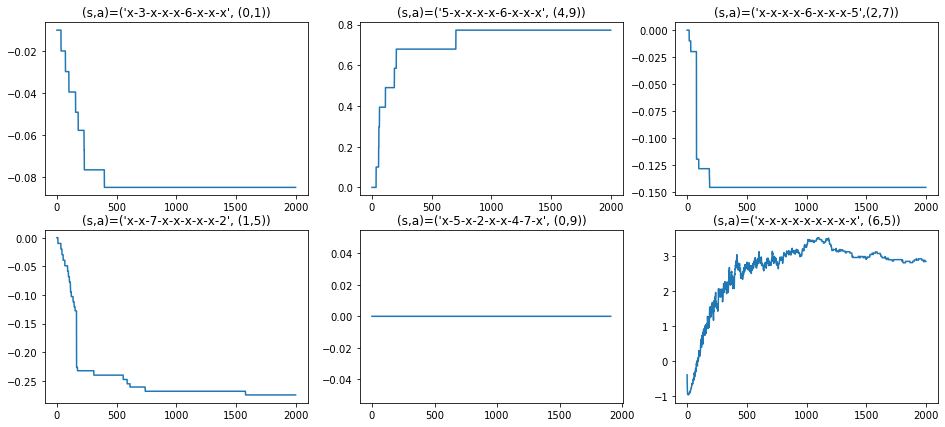

In [19]:
# Write the code for plotting the graphs for state-action pairs tracked
plt.figure(figsize=(16, 7))

plt.subplot(2, 3, 1)
p1 = States_track['x-3-x-x-x-6-x-x-x'][(0, 1)]
plt.title("(s,a)=('x-3-x-x-x-6-x-x-x', (0,1))")
plt.plot(np.asarray(range(0, len(p1))), np.asarray(p1))

plt.subplot(2, 3, 2)
p2 = States_track['5-x-x-x-x-6-x-x-x'][(4, 9)]
plt.title("(s,a)=('5-x-x-x-x-6-x-x-x', (4,9))")
plt.plot(np.asarray(range(0, len(p2))), np.asarray(p2))

plt.subplot(2, 3, 3)
p3 = States_track['x-x-x-x-6-x-x-x-5'][(2, 7)]
plt.title("(s,a)=('x-x-x-x-6-x-x-x-5',(2,7))")
plt.plot(np.asarray(range(0, len(p3))), np.asarray(p3))

plt.subplot(2, 3, 4)
p4 = States_track['x-x-7-x-x-x-x-x-2'][(1, 5)]
plt.title("(s,a)=('x-x-7-x-x-x-x-x-2', (1,5))")
plt.plot(np.asarray(range(0, len(p4))), np.asarray(p4))

plt.subplot(2, 3, 5)
p5 = States_track['x-5-x-2-x-x-4-7-x'][(0, 9)]
plt.title("(s,a)=('x-5-x-2-x-x-4-7-x', (0,9))")
plt.plot(np.asarray(range(0, len(p5))), np.asarray(p5))

plt.subplot(2, 3, 6)
p6 = States_track['x-x-x-x-x-x-x-x-x'][(6, 5)]
plt.title("(s,a)=('x-x-x-x-x-x-x-x-x', (6,5))")
plt.plot(np.asarray(range(0, len(p6))), np.asarray(p6))

plt.show()

### Epsilon - decay check

In [20]:
max_epsilon = 1.0
min_epsilon = 0.001
ep_time = np.arange(0, 5_000_000)
epsilon = []
for i in range(0, 5_000_000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000002 * i))

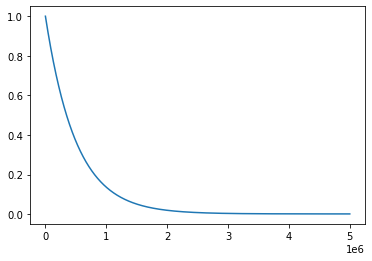

In [21]:
plt.plot(ep_time, epsilon)
plt.show()